# Loading Data and creating Dataset

In [1]:
!kaggle datasets download -d arnaudeq/cats-vs-dogs-1000

Dataset URL: https://www.kaggle.com/datasets/arnaudeq/cats-vs-dogs-1000
License(s): unknown
 96% 170M/177M [00:01<00:00, 94.9MB/s]
100% 177M/177M [00:01<00:00, 99.7MB/s]


In [2]:
!unzip -q cats-vs-dogs-1000.zip -d dataset

In [3]:
import glob

cats_train = glob.glob('/content/dataset/dogs_cats_sample_1000/train/cats/*.jpg')
dogs_train = glob.glob('/content/dataset/dogs_cats_sample_1000/train/dogs/*.jpg')

cats_val = glob.glob('/content/dataset/dogs_cats_sample_1000/valid/cats/*.jpg')
dogs_val = glob.glob('/content/dataset/dogs_cats_sample_1000/valid/dogs/*.jpg')

In [4]:
len(cats_train), len(dogs_train), len(cats_val), len(dogs_val)

(1000, 1000, 1002, 998)

**`Testing how images look after Normalization`**

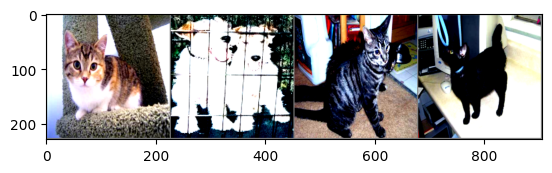

cats dogs cats cats


In [10]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the size your model expects
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Create the dataset
training_folder = '/content/dataset/dogs_cats_sample_1000/train'
train_dataset = ImageFolder(root=training_folder, transform=transform)

# Create a DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Get a batch of training data
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
print(' '.join(f'{train_dataset.classes[labels[j]]}' for j in range(4)))

In [79]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
import torch.nn as nn # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torchvision.datasets as datasets # Has standard datasets we can import in a nice way
import torchvision.transforms as transforms # Transformations we can perform on our dataset
import torch.nn.functional as F # All functions that don't have any parameters
from torch.utils.data import DataLoader, Dataset, Subset # Gives easier dataset managment and creates mini batches
from torchvision.datasets import ImageFolder
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
from PIL import Image

In [65]:
class ImageLoader(Dataset):
  def __init__(self, dataset, labels, transform=None):
    self.dataset = self.check_channel(dataset)
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, index) :
    image = Image.open(self.dataset[index][0])
    label = self.labels[index]
    if self.transform:
      image = self.transform(image)
    return (image, label)

  def check_channel(self, dataset):
    dataset_with_only_rgb = []
    for i in range(len(dataset)):
      if Image.open(dataset[i][0]).getbands() == ('R', 'G', 'B'):
        dataset_with_only_rgb.append(dataset[i])
    return dataset_with_only_rgb

In [25]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize([0.5]*3, [0.5]*3)
]) # transform


In [48]:
# Load datasets
train_dataset = ImageFolder('/content/dataset/dogs_cats_sample_1000/train/', transform=transform)

# Extract file paths and labels
train_data = train_dataset.imgs
labels = train_dataset.targets

In [66]:
train_dataset = ImageLoader(train_data, labels, transform)

In [67]:
len(train_data)

2000

In [68]:
len(train_dataset)

2000

In [69]:
train_dataLoader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [70]:
len(train_dataLoader)

63

# Model Training

In [71]:
from tqdm import tqdm
from torchvision import models

In [56]:
model = models.resnet50(pretrained=True)

# For Finetuning set requires_grad = False

for param in model.parameters():
  param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 126MB/s]


In [57]:
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

In [58]:
num_features

2048

In [59]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [60]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [61]:
device

device(type='cpu')

In [62]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [63]:
def train(model, device, train_loader, optimizer, epochs):
  for epoch in range(1, epochs + 1):
    model.train()
    losses = []
    tqdm_loader = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx, (data, target) in tqdm_loader:
      data, target = data.to(device), target.to(device)

      output = model(data)
      loss = criterion(output, target)
      losses.append(loss.item())
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      tqdm_loader.set_description(f"Epoch {epoch+1}/{epochs} process: {int((batch_idx / len(train_loader)) * 100)}")
      tqdm_loader.set_postfix(loss=loss.data.item())

            # save model
    torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, 'checpoint_epoch_'+str(epoch)+'.pt')

In [73]:
train(model = model, device = device, train_loader= train_dataLoader, optimizer=optimizer, epochs= 5)

Epoch 6/5 process: 98: 100%|██████████| 63/63 [09:47<00:00,  9.33s/it, loss=0.0112]


In [74]:
val_dataset = ImageFolder('/content/dataset/dogs_cats_sample_1000/valid/', transform=transform)

In [76]:
len(val_dataset)

2000

In [95]:

val_dataset = ImageFolder('/content/dataset/dogs_cats_sample_1000/valid/', transform=transform)

# Calculate the number of samples for 10% of the validation dataset
num_samples = int(0.1 * len(val_dataset))
indices = torch.randperm(len(val_dataset)).tolist()[:num_samples]

# Create the subset
val_subset = Subset(val_dataset, indices)

val_subset_image_paths = [val_dataset.imgs[idx] for idx in indices]
val_subset_labels = [val_dataset.imgs[idx][1] for idx in indices]

test_dataset = ImageLoader(val_subset_image_paths, val_subset_labels, transform)

In [96]:
len(val_subset_image_paths), len(val_subset_labels)

(200, 200)

In [97]:
test_dataLoader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# Model testing

In [98]:
def test(model, device, criterion, test_loader):
  model.eval()
  correct = 0
  loss = 0
  total = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)

      _, pred = torch.max(output.data, 1)
      correct += pred.eq(target.data).sum().item()
      loss = criterion(output, target)
      total += target.size(0)
  return correct/total, loss

In [99]:
accuracy, loss = test(model, device, criterion, test_dataLoader)

In [102]:
print("Accuracy: ", accuracy * 100, "%")
print("Loss: ", loss.item() * 100, "%")

Accuracy:  98.5 %
Loss:  1.4670283533632755 %


In [103]:
def ImagePrediction(filepath, model):
    img_array = Image.open(filepath).convert("RGB")
    img_array.show()

    data_transforms = transforms.Compose([
    transforms.Resize((512, 512)),
    # transforms.Lambda(convert_channels),  # Custom transform to handle 4 or 1 channel images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5341, 0.5063, 0.4630], std=[0.2098, 0.2081, 0.2181])
    ])

    img = data_transforms(img_array).unsqueeze(dim=0) # Returns a new tensor with a dimension of size one inserted at the specified position.
    load = DataLoader(img)

    for x in load:
        x=x.to(device)
        pred = model(x)
        # print(pred)
        _, preds = torch.max(pred, 1)
        print(f"class : {preds}")
        if preds[0] == 1: print(f"predicted ----> Dog")
        else: print(f"predicted ----> Cat")

        # Apply sigmoid to convert logits to probabilities
        probabilities = torch.sigmoid(pred)

        # # Apply threshold (0.5) to determine class prediction
        print(probabilities)
        predicted_class = (probabilities >= 0.5).float()

        if(torch.argmax(probabilities).item()   == 1):
          print("Dog")
        else:
          print("Cat")

# Test with a new Image

In [106]:
ImagePrediction('/content/images.jpg', model)

class : tensor([0])
predicted ----> Cat
tensor([[0.9081, 0.1371]], grad_fn=<SigmoidBackward0>)
Cat
